<a href="https://colab.research.google.com/github/vaguiarfinance/AprendizadoDNC/blob/main/Algoritmo_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#Vamos importar a biblioteca do ARIMA - Algoritmo
from statsmodels.tsa.arima.model import ARIMA

In [2]:
!pip install scipy

In [3]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.1 MB/s eta 0:00:00


In [4]:
from pmdarima.arima import auto_arima

In [12]:
df = pd.read_excel("energy.xlsx", index_col= "DATE", parse_dates=True)
df.head()

,energy
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [13]:
df.shape

(408, 1)

In [14]:
df.describe()

,energy
count,408.000000
mean,88.062232
std,15.168540
min,54.616500
25%,76.499750
50%,88.940450
75%,99.733200
max,126.362600


In [15]:
# Vamos ver qual é a data inicial e a final

df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

In [16]:
df.columns = ["producao"]

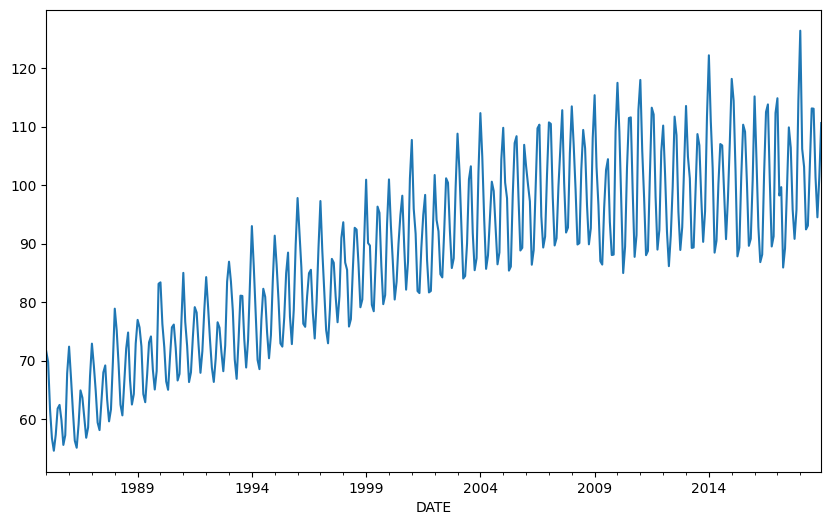

In [17]:
df["producao"].plot(figsize=(10,6));

<Figure size 800x600 with 0 Axes>

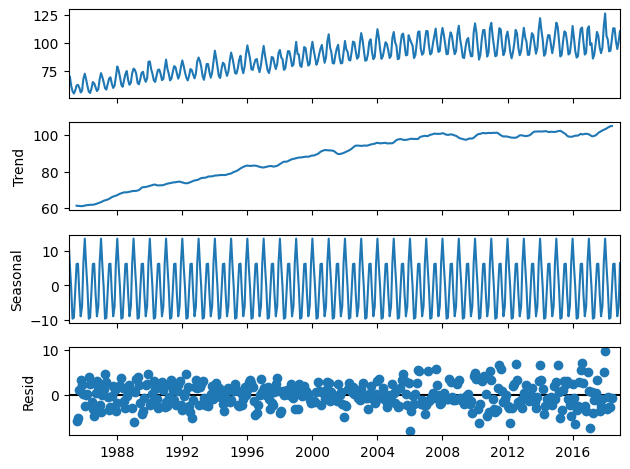

In [18]:
# Verificando se existe sazonalidade ou não, através de uma métrica

from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df)

fig = plt.figure(figsize=(8,6))
fig = resultado.plot()

Um bom parametro de avaliação de sazonalidade é o P-Value, caso seja superior a 5% digo que a hipóteses nula é verdadeira, logo a série não é estacionária.

In [19]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["producao"].dropna())
print(f"Teste ADF:{result[0]}")
print(f"P_Valor:{result[1]}")

Teste ADF:-2.252399047046594
P_Valor:0.18777984601967806


In [21]:
from statsmodels.tsa.stattools import adfuller

# Ao acrescentar o diff (pega o valor seguinte e subtrai pelo anterior)
result = adfuller(df["producao"].diff().dropna())
print(f"Teste ADF:{result[0]}")
print(f"P_Valor:{result[1]}")

Teste ADF:-7.450892277526341
P_Valor:5.67456995585561e-11


Com isso, notamos que o P_valor ficou abaixo dos 5% tornando o a série estacionária. Vide a notação cientifica ao final do valor (-11)

Assim podemos descartar a hipótese nula e seguiremos com o modelo

In [22]:
# Definindo o melhor parâmetro para a minha base

fit_arima = auto_arima(df, d=1, start_p = 1, start_q = 1, max_p = 3, max_q =3,
                       seasonal= True,
                       m=6,
                       D=1,
                       start_P=1,
                       start_Q=1,
                       max_P=2,
                       max_Q=2,
                       information_criterion="aic",
                       trace=True,
                       error_action="ignore",
                       stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1968.148, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2494.965, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=2053.701, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2128.799, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2064.883, Time=0.34 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1928.298, Time=0.63 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=1868.200, Time=1.37 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=1866.400, Time=1.05 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=2014.153, Time=0.52 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=1916.488, Time=0.76 sec
 ARIMA(1,1,0)(1,1,2)[6]             : AIC=1936.850, Time=0.69 sec
 ARIMA(2,1,1)(1,1,2)[6]             : AIC=1868.120, Time=1.38 sec
 ARIMA(1,1,2)(1,1,2)[6]             : AIC=1

In [24]:
# Uma vez que a série apresenta sazonalidade, iremos utilizar o SARIMAX

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df, order=(1,1,1), seasonal_order=(1,1,2,6))
resultado_sarimax = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [25]:
# vamos verificar o resultado deste modelo

resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                               producao   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 6)   Log Likelihood                -927.200
Date:                                Fri, 11 Aug 2023   AIC                           1866.400
Time:                                        18:51:27   BIC                           1890.364
Sample:                                    01-01-1985   HQIC                          1875.889
                                         - 12-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5125      0.042     12.156      0.000       0.430       0.595
ma.L1         -0.9601      0.017    -56.250      0.000      -0.994      -0.927
ar.S.L6       -0.9973      0.003   -350.055      0.000      -1.003      -0.992
ma.S.L6        0.1026      0.037      2.775      0.006       0.030       0.175
ma.S.L12      -0.7748      0.035    -22.180      0.000      -0.843      -0.706
sigma2         5.6413      0.322     17.544      0.000       5.011       6.272
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                29.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [28]:
# Avaliando o intervalo de confiança do modelo gerado

intervalo_confianca = predicoes.conf_int()
limite_abaixo = intervalo_confianca.iloc[:,0]
limite_acima = intervalo_confianca.iloc[:,1]

limite_abaixo[0], limite_acima[0]

(115.1447404570401, 124.45517675290846)

In [29]:
predicao_media[0]

119.79995860497428

In [30]:
# Agora vamos de fato, fazer a predição

datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

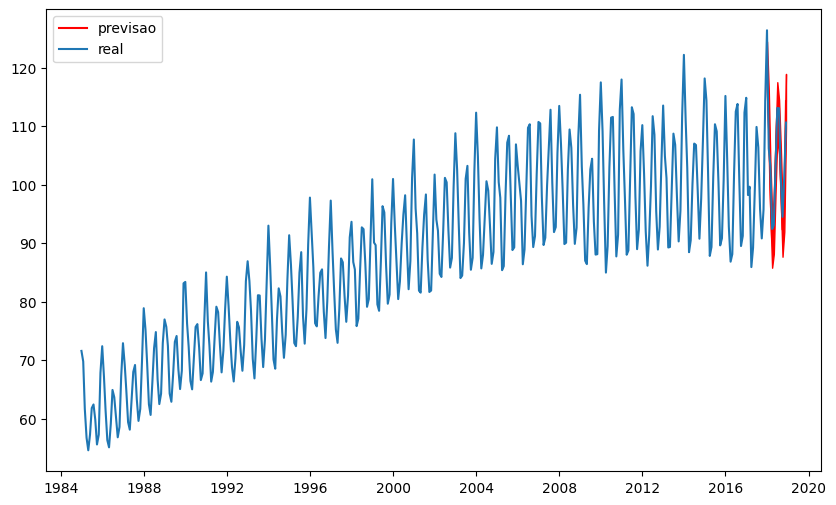

In [32]:
# Plotando o gráfico da previsão

plt.figure(figsize=(10,6))
plt.plot(datas_previsao, predicao_media.values, color = "red", label = "previsao")
plt.fill_between(datas_previsao, limite_abaixo, limite_acima, color="red")
plt.plot(datas,df.values,label="real")
plt.legend()
plt.show()

In [33]:
# Podemos tirar o R^2 para analisarmos a aceitação do MOdelo

from sklearn.metrics import mean_absolute_error

# Definimos como -12 dias passados
mae = mean_absolute_error(df[-12:].values,predicao_media.values)
print(mae)

2.7071201498891306


Notamos que o modelo apresentou uma baixa margem de erro.

In [34]:
# Vamos avaliar a predição futura - FORECAST

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [35]:
# Vamos tirar o intervalo de confiança

intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]


(91.38813005236821, 103.10930985132882)

In [36]:
forecast_medio[10]

97.24871995184851

In [39]:
datas_forecast = np.asarray(forecast_medio.index)
pred_datas = np.asarray(predicao_media.index)

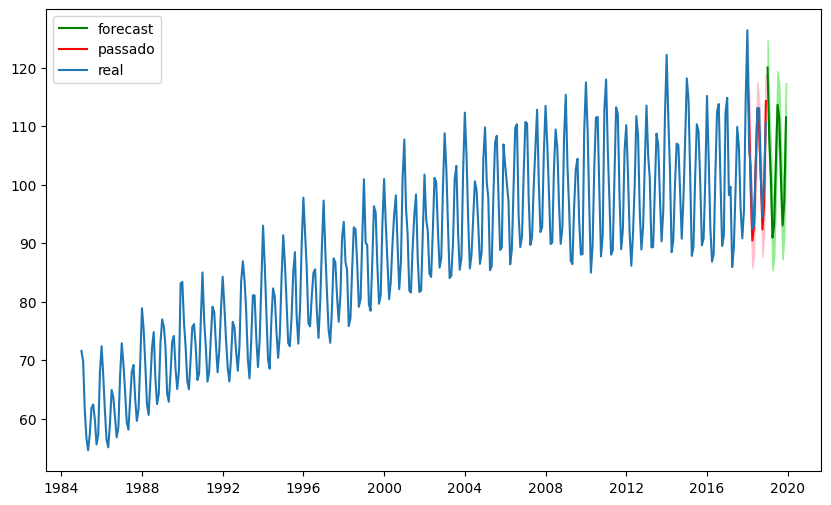

In [42]:
dates = np.asarray(df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast, forecast_medio.values, color = "green", label="forecast")
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color = "lightgreen")

plt.plot(datas_previsao, predicao_media.values, color = "red", label="passado")
plt.fill_between(datas_previsao, limite_abaixo, limite_acima, color = "pink")

plt.plot(dates, df.values, label="real")
plt.legend(loc="upper left")
plt.show()